# Permeation with trapping

In [1]:
import festim as F
import numpy as np

L = 3e-04
vertices = np.linspace(0, L, num=1000)

my_mesh = F.Mesh1D(vertices)

my_model = F.HydrogenTransportProblem()
my_model.mesh = my_mesh

my_mat = F.Material(D_0=1.9e-7, E_D=0.2, name="my_mat")
my_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, L], material=my_mat)
left_surface = F.SurfaceSubdomain1D(id=1, x=0)
right_surface = F.SurfaceSubdomain1D(id=2, x=L)
my_model.subdomains = [
    my_subdomain,
    left_surface,
    right_surface,
]

mobile_H = F.Species("H")
trapped_H = F.Species("trapped_H", mobile=False)
empty_trap = F.ImplicitSpecies(n=1e19, others=[trapped_H], name="empty_trap")
my_model.species = [mobile_H, trapped_H]

my_model.reactions = [
    F.Reaction(
        p_0=1e13,
        E_p=1.2,
        k_0=3.8e-17,
        E_k=0.2,
        reactant1=mobile_H,
        reactant2=empty_trap,
        product=trapped_H,
        volume=my_subdomain,
    )
]

my_model.temperature = 500

my_model.boundary_conditions = [
    F.DirichletBC(subdomain=right_surface, value=0, species="H"),
    F.DirichletBC(subdomain=left_surface, value=1e12, species=mobile_H),
]
my_model.exports = [
    F.VTXExport("mobile_concentration_h.bp", field=mobile_H),  # produces 0 in file
    F.VTXExport("trapped_concentration_h.bp", field=trapped_H),  # produces 0 in file
    F.XDMFExport("mobile_concentration_h.xdmf", field=mobile_H),
    F.XDMFExport("trapped_concentration_h.xdmf", field=trapped_H),
    F.SurfaceFlux(field=mobile_H, surface=right_surface),
]

my_model.settings = F.Settings(
    atol=1e10,
    rtol=1e-10,
    max_iterations=30,
    final_time=50,
)

my_model.settings.stepsize = F.Stepsize(initial_value=1 / 20)

my_model.initialise()

from petsc4py import PETSc

my_model.solver.convergence_criterion = "incremental"
ksp = my_model.solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

my_model.run()

Solving H transport problem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

Text(0, 0.5, 'Surface flux (H/m²/s)')

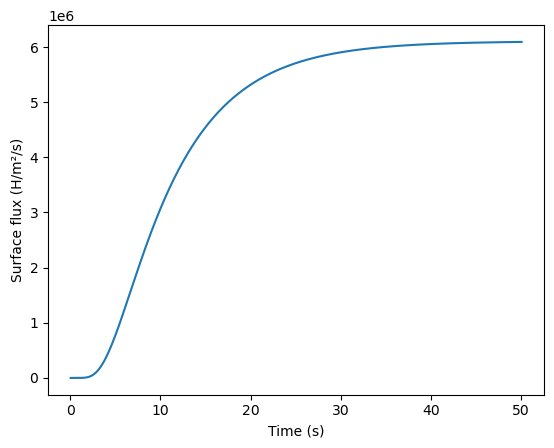

In [2]:
import matplotlib.pyplot as plt
surf_flux = my_model.exports[-1]
plt.plot(surf_flux.t, surf_flux.data)
plt.xlabel("Time (s)")
plt.ylabel("Surface flux (H/m²/s)")